# Variational Autoencoder on MNIST data
- Link to original notebook, by F. Chollet: http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb
- VAE on MNIST with tensorflow: https://jmetzen.github.io/2015-11-27/vae.html
- Visualizing VAE on MNIST: https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

I only added the last part on visualizing the latent space. The rest of the notebook is the same as the original notebook by F. Chollet.

# Data

In [1]:
import numpy as np

from keras.datasets import mnist

(train_samples, train_labels), (test_samples, test_labels) = mnist.load_data()

# Normalize data
def normalize_samples(samples):
    samples = np.reshape(samples, [-1, 28*28])
    return samples.astype('float') / 255. # np.expand_dims( samples.astype('float') / 255. , axis=-1)

train_samples = normalize_samples(train_samples)
test_samples = normalize_samples(test_samples)

input_shape = train_samples.shape[1:]

Using TensorFlow backend.


# VAE model

In [7]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Input, Lambda, Flatten, Reshape
import keras.backend as K

def sampling(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    latent_dimension = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch_size, latent_dimension))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

latent_dimension = 20

inputs = Input(shape=input_shape, name='encoder_input')
# x = Flatten()(inputs)
x = Dense(512, activation='relu')(inputs)
z_mean = Dense(latent_dimension, name='z_mean')(x)
z_log_var = Dense(latent_dimension, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dimension,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dimension,), name='z_sampling')
x = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(np.product(input_shape), activation='sigmoid')(x)
# outputs = Reshape(input_shape)(outputs)

decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Losses

In [8]:
# Weight for BCE, balancing black and white pixels
1 / np.mean(train_samples)

7.653423808927225

In [9]:
from keras.losses import binary_crossentropy

alpha, beta = 20, 1

def weighted_binary_crossentropy(y_true, y_pred, alpha):
    return - K.sum(alpha * y_true * K.log(y_pred + K.epsilon()) +  (1 - y_true) * K.log((1 - y_pred) + K.epsilon()), axis=-1)

reconstruction_loss = weighted_binary_crossentropy(inputs, outputs, alpha=alpha)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.metrics_names.append('KL')
vae.metrics_tensors.append(K.mean(kl_loss))
vae.metrics_names.append('Rec')
vae.metrics_tensors.append(K.mean(reconstruction_loss))

In [9]:
# save weights before training
# Wsave = vae.get_weights()
vae.set_weights(Wsave)

# Train

In [6]:
vae.fit(train_samples, batch_size=128, epochs=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 5s 77us/step - loss: 751.2440 - KL: 16.0427 - Rec: 735.2013
Epoch 2/50
60000/60000 [==============================] - 4s 66us/step - loss: 628.2828 - KL: 7.9355 - Rec: 620.3473
Epoch 3/50
60000/60000 [==============================] - 4s 66us/step - loss: 605.7484 - KL: 8.0461 - Rec: 597.7023
Epoch 4/50
60000/60000 [==============================] - 4s 66us/step - loss: 592.9129 - KL: 8.1706 - Rec: 584.7423
Epoch 5/50
60000/60000 [==============================] - 4s 67us/step - loss: 584.1244 - KL: 8.2484 - Rec: 575.8760
Epoch 6/50
60000/60000 [==============================] - 4s 65us/step - loss: 577.3446 - KL: 8.3462 - Rec: 568.9984
Epoch 7/50
60000/60000 [==============================] - 4s 66us/step - loss: 572.2398 - KL: 8.3793 - Rec: 563.8605
Epoch 8/50
60000/60000 [==============================] - 4s 66us/step - loss: 568.0319 - KL: 8.3888 - Rec: 559.6431
Epoch 9/50
6000

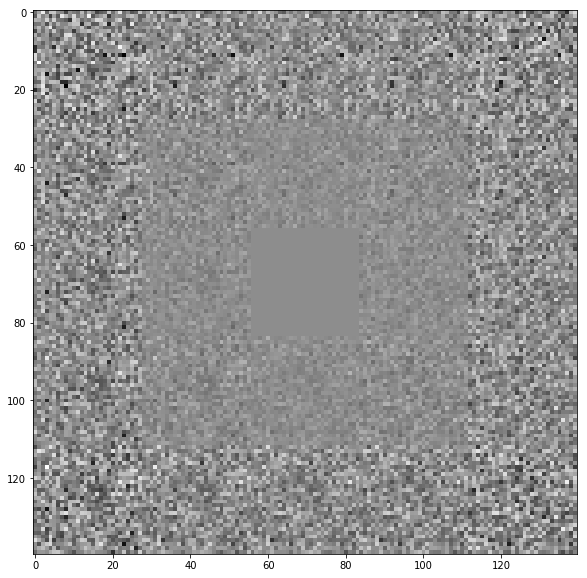

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import norm
batch_size = 64
# Display a 2D manifold of the digits
n = 5  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size*latent_dimension//2).reshape(batch_size, latent_dimension)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

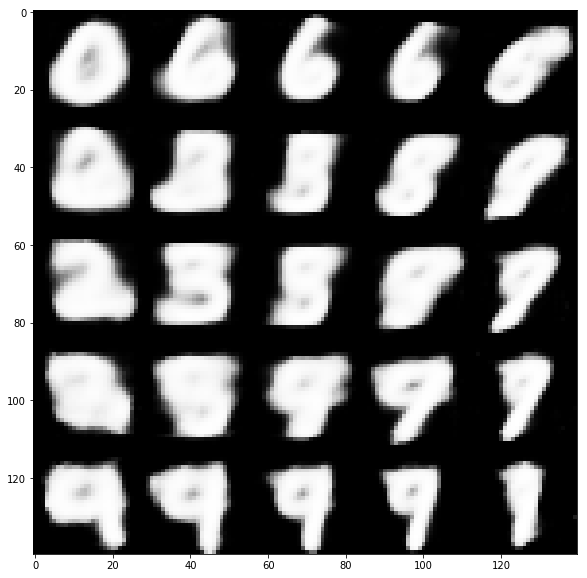

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm
batch_size = 64
# Display a 2D manifold of the digits
n = 5  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dimension)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.

# Visualize latent space
inspierd by https://jmetzen.github.io/2015-11-27/vae.html

In [45]:
# Activation model
activation_model = Model(inputs=vae.input, outputs=vae.layers[-3].output)

z_mu = activation_model.predict(x_test)

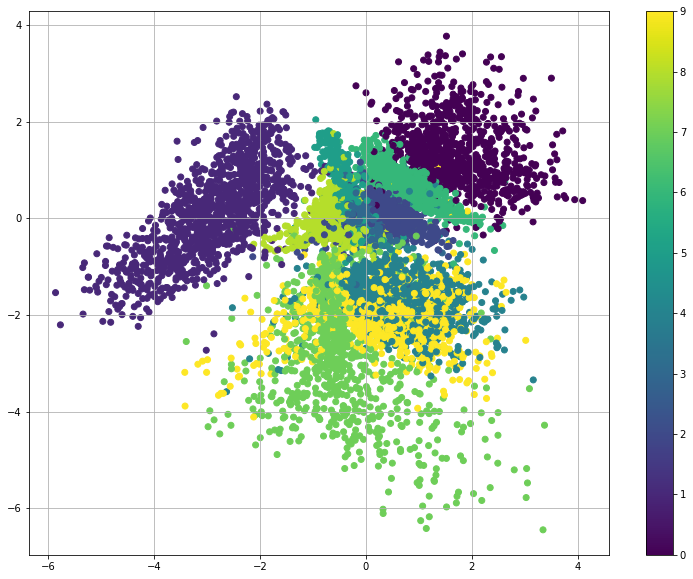

In [51]:
from matplotlib import pyplot as plt
plt.figure(figsize=(13,10))
plt.scatter(z_mu[:,0], z_mu[:,1], c=y_test)
plt.colorbar()
plt.grid()